# Small Nimmt 6 tournament

In [1]:
import numpy as np
import logging
import sys
import torch
import pickle
from tqdm import tqdm
from matplotlib import pyplot as plt

sys.path.append("../")

from rl_6_nimmt import Tournament, GameSession
from rl_6_nimmt.agents import Human, DrunkHamster, BatchedReinforceAgent, BatchedACERAgent, Noisy_D3QN_PRB_NStep

logging.basicConfig(format="%(message)s",level=logging.INFO)
for name in logging.root.manager.loggerDict:
    if not "rl_6_nimmt" in name:
        logging.getLogger(name).setLevel(logging.WARNING)


## Agents

In [2]:
agents = {}
    
agents[f"DQN 1"] = Noisy_D3QN_PRB_NStep(history_length=int(1e5), n_steps=1)
agents[f"DQN 10"] = Noisy_D3QN_PRB_NStep(history_length=int(1e5), n_steps=10)
agents[f"REINFORCE"] = BatchedReinforceAgent(r_factor=0.1)
agents[f"ACER 4"] = BatchedACERAgent(minibatch=4)
agents[f"ACER 10"] = BatchedACERAgent(minibatch=10)

for agent in agents.values():
    agent.train()
    
agents[f"Random"] = DrunkHamster()
    
baseline_agents = [DrunkHamster(), DrunkHamster(), DrunkHamster()]

merle = Human("Merle")


In [ ]:
tournament = Tournament(min_players=2, max_players=6, baseline_agents=baseline_agents)

for name, agent in agents.items():
    tournament.add_player(name, agent)

print(tournament)

## Load existing state (skip when running this for the first time)

In [ ]:
# agents, tournament = pickle.load(open("./.tournament.pickle", "rb"))

## Let the games begin

In [5]:
num_games = 100000
block_len = 10000

try:
    tqdm._instances.clear()  # Important after cancelling any step
except:
    pass

while tournament.total_games < num_games:
    for _ in tqdm(range(block_len)):
        tournament.play_game()
    print(tournament)


  0%|          | 20/10000 [00:02<19:48,  8.39it/s] 


KeyboardInterrupt: 

In [40]:
pickle.dump((agents, tournament), open( "./.tournament.pickle", "wb" ))

## Let's see the results

In [41]:
print(tournament)

Tournament after 19425 games:
----------------------------------------------------------------------------------------------------
 Agent                | Games | Tournament score | Tournament wins | Baseline score | Baseline wins 
----------------------------------------------------------------------------------------------------
                DQN 1 | 12956 |           -13.62 |            0.18 |         -13.70 |          0.21 
               DQN 10 | 13087 |           -12.37 |            0.23 |         -12.17 |          0.25 
            REINFORCE | 12952 |           -12.78 |            0.22 |         -12.07 |          0.29 
               ACER 4 | 13027 |            -9.78 |            0.32 |         -10.04 |          0.33 
              ACER 10 | 13058 |            -9.45 |            0.32 |          -9.30 |          0.37 
               Random | 12951 |           -12.64 |            0.23 |         -12.10 |          0.26 
-------------------------------------------------------------

In [42]:
def plot_running_mean(x, y, n=10, **kwargs):
    cumsum = np.cumsum(np.insert(y, 0, 0))
    running_mean_y = (cumsum[n:] - cumsum[:-n]) / n
    
    cumsum = np.cumsum(np.insert(x, 0, 0))
    running_mean_x = (cumsum[n:] - cumsum[:-n]) / n
    
    plt.plot(running_mean_x, running_mean_y, **kwargs)


In [43]:
labels = [
    "Mean Hornochsen in tournament",
    "Mean Hornochsen vs baseline",
    "Win fraction in tournament",
    "Win fraction vs baseline"
]
quantities = [
    tournament.tournament_scores,
    tournament.baseline_scores,
    tournament.tournament_wins,
    tournament.baseline_wins
]
fns = [lambda x : -x, lambda x : -x, lambda x : x, lambda x : x]
baselines = [False, True, False, True]

colors = {
    "DQN 1": "C0",
    "DQN 10": "C0",
    "REINFORCE": "C1",
    "ACER 4": "C2",
    "ACER 10": "C2",
    "Random": "0.7",
}
lss = {
    "DQN 1": ":",
    "DQN 10": "-",
    "REINFORCE": "-",
    "ACER 4": ":",
    "ACER 10": "-",
    "Random": ":",
}

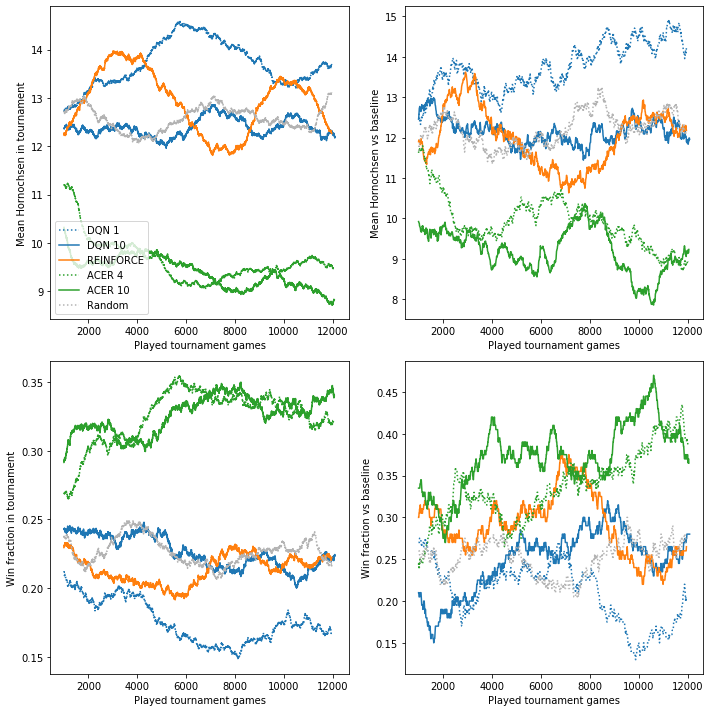

In [47]:
fig = plt.figure(figsize=(10,10))

for panel, (quantity, label, fn, baseline) in enumerate(zip(quantities, labels, fns, baselines)):
    ax = plt.subplot(2,2,panel + 1)
    
    for name in tournament.agents.keys():
        y = np.array(quantity[name])
        x = 10 * np.arange(1, len(y) + 1) if baseline else np.arange(1, len(y) + 1)
        plot_running_mean(x, fn(y), n=200 if baseline else 2000, label=name, color=colors[name], ls=lss[name])
    
    if panel == 0:
        plt.legend(loc="lower left")
        
    plt.xlabel("Played tournament games")
    plt.ylabel(label)

plt.tight_layout()
plt.savefig("tournament_results.pdf")


## Winner vs Merle

In [50]:
session = GameSession(merle, agents["ACER 4"], agents["ACER 10"], agents["REINFORCE"])

# The DEBUG output shows the moves, which is nice
for name in logging.root.manager.loggerDict:
    if "rl_6_nimmt" in name:
        logging.getLogger(name).setLevel(logging.DEBUG)
        

In [51]:
session.play_game(render=True)

Dealing cards
------------------------------------------------------------------------------------------------------------------------
Board:
   33+   _    _    _    _    * 
   76    _    _    _    _    * 
   79    _    _    _    _    * 
    6    _    _    _    _    * 
Players:
  Merle     (player 1):   0 Hornochsen, cards   1    3    9   19   24   53   62   64   66+  78 
  ACER 4    (player 2):   0 Hornochsen, cards  11+  25.  35.  52   67   69   74   75.  80:  84 
  ACER 10   (player 3):   0 Hornochsen, cards  10:  12   21   28   46   50:  51   87   95. 100:
  REINFORCE (player 4):   0 Hornochsen, cards   8   42   45.  56   65.  71   85.  89   99+ 104 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:   1   3   9  19  24  53  62  64  66  78. Choose one to play! 9


RuntimeError: invalid multinomial distribution (encountering probability entry < 0)